# Overlap Score Demo
### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib.image import imread
from typing import Tuple

from megadepth.utils.read_write_dense import read_array
from megadepth.utils.read_write_model import read_cameras_binary, read_images_binary, qvec2rotmat

In [3]:
def plot_images(images: list, titles: list) -> None:
    fig = plt.figure(figsize=(18, 24))

    for i in range(len(images)):
        fig.add_subplot(1, len(images), i+1)
        plt.axis("off")
        plt.imshow(images[i])
        plt.title(titles[i])
 
    plt.show()


def get_K_R_t(
    camera: namedtuple, 
    image: namedtuple,
    invert: bool = False,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # used https://github.com/colmap/colmap/blob/dev/scripts/python/visualize_model.py as a guide for this function

    # rotation
    R = qvec2rotmat(image.qvec)

    # translation
    t = image.tvec

    # intrinsics
    if camera.model in ("SIMPLE_PINHOLE", "SIMPLE_RADIAL", "RADIAL"):
        fx = fy = camera.params[0]
        cx = camera.params[1]
        cy = camera.params[2]
    elif camera.model in ("PINHOLE", "OPENCV", "OPENCV_FISHEYE", "FULL_OPENCV"):
        fx = camera.params[0]
        fy = camera.params[1]
        cx = camera.params[2]
        cy = camera.params[3]
    else:
        raise Exception("Camera model not supported")
    
    K = np.identity(3)
    K[0, 0] = fx
    K[1, 1] = fy
    K[0, 2] = cx
    K[1, 2] = cy

    # invert for backprojection
    if invert:
        t = -R.T @ t
        R = R.T
        K = np.linalg.inv(K)

    return K, R, t


### Computation of Overlap Score
Change the following image IDs to compute the overlap score of another image pair:

In [4]:
id_1 = 26
id_2 = 27

Let us plot the corresponding images and depth maps

../../MegaDepthData/south-building/dense/0


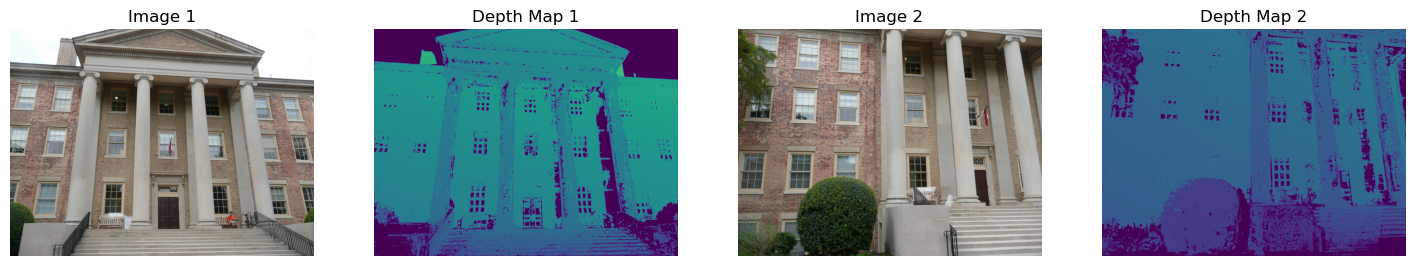

In [7]:
# output directory of the dense reconstruction pipeline
dense_dir = os.path.join("..","..","MegaDepthData", "south-building", "dense", "0") 
print(dense_dir)
# key: camera ID, value: camera model and parameters
camera_dict = read_cameras_binary(os.path.join(dense_dir, "sparse", "cameras.bin"))
# key: image ID, value: camera ID, camera pose, feature points
image_dict = read_images_binary(os.path.join(dense_dir, "sparse", "images.bin"))

name_1 = image_dict[id_1].name
name_2 = image_dict[id_2].name

img_1 = imread(os.path.join(dense_dir, "images", name_1))
img_2 = imread(os.path.join(dense_dir, "images", name_2))

depth_1 = read_array(os.path.join(dense_dir, "stereo", "depth_maps", f"{name_1}.geometric.bin"))
depth_2 = read_array(os.path.join(dense_dir, "stereo", "depth_maps", f"{name_2}.geometric.bin"))

plot_images([img_1, depth_1, img_2, depth_2], ["Image 1", "Depth Map 1", "Image 2", "Depth Map 2"])

For each pixel **p1** in image 1:
1. If **d1** is a valid depth value, backproject **p1** to 3D space to obtain point **P** with distance **d1** from camera 1.
2. Project **P** to the image space of the image 2 to get pixel coordinates **(x, y)**.
3. If pixel **(x, y)** lies inside image 2 and the depth value **d2** at **(x, y)** is a valid depth value, check if it roughly equals to the distance between **P** and camera 2.

image_1 = image_dict[id_1]
image_2 = image_dict[id_2]

camera_1 = camera_dict[image_1.camera_id]
camera_2 = camera_dict[image_2.camera_id]

K1, R1, t1 = get_K_R_t(camera=camera_1, image=image_1, invert=True)
K2, R2, t2 = get_K_R_t(camera=camera_2, image=image_2, invert=False) # K2 transforms from normalized to pixel
print(camera2.height, camera2.width)
K1

In [8]:
image_1 = image_dict[id_1]
image_2 = image_dict[id_2]

camera_1 = camera_dict[image_1.camera_id]
camera_2 = camera_dict[image_2.camera_id]

K1, R1, t1 = get_K_R_t(camera=camera_1, image=image_1, invert=False)
K2, R2, t2 = get_K_R_t(camera=camera_2, image=image_2, invert=True)

# from norm to pixel
p_norm = np.array([0.0,0.0,1]) # (x,y,1)
p_pixel = K1 @ p_norm
print(p_pixel.astype(int))

# from pixel to norm
p_pixel = np.array([1200,896.5,1]) # (x,y,1)
p_norm = K2 @ p_pixel
print(p_norm)

print(camera_1.width, camera_1.height)
print(K1)
print(K1[0,2],K1[1,2])

[1200  896    1]
[0. 0. 1.]
2400 1793
[[1.98223139e+03 0.00000000e+00 1.20000000e+03]
 [0.00000000e+00 1.98178199e+03 8.96500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
1200.0 896.5


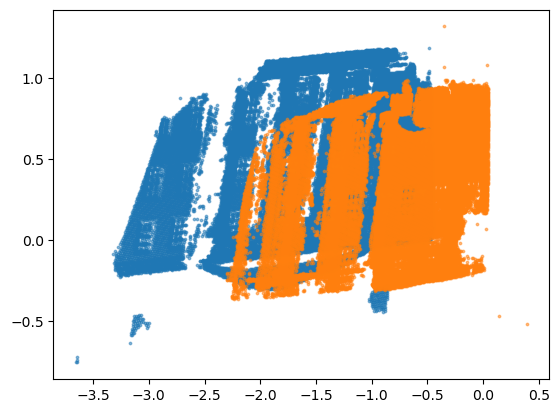

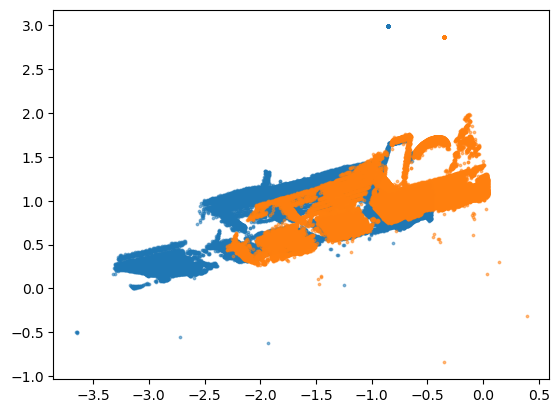

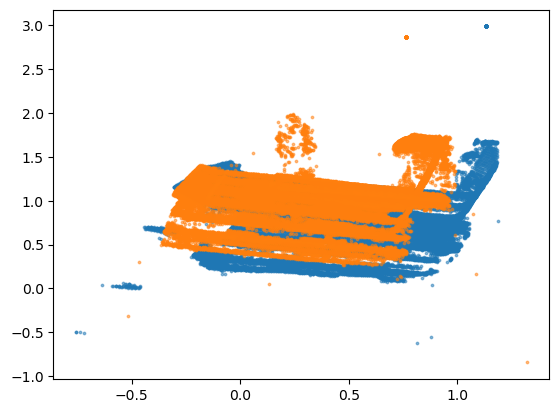

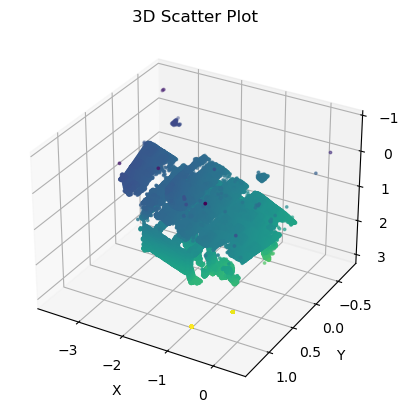

In [9]:
def assemble_homog_pixel_vector(width, height, down_sample):
    """Sample pixel coordinates from the camera frame on a grid."""
    x = np.linspace(0, width-1, width)[::down_sample]
    y = np.linspace(0, height-1, height)[::down_sample]
    xv, yv = np.meshgrid(x, y)
    xv = np.ravel(xv)
    yv = np.ravel(yv)
    return np.vstack((xv,yv,np.zeros_like(xv)))

def backproject(id_1, down_sample=10):
    image_1 = image_dict[id_1]
    name_1 = image_dict[id_1].name
    camera_1 = camera_dict[image_1.camera_id]
    _, R1, t1 = get_K_R_t(camera=camera_1, image=image_1, invert=False)
    K1, _,_ = get_K_R_t(camera=camera_1, image=image_1, invert=True)
    homog_pixel_vector = assemble_homog_pixel_vector(camera_1.width,camera_1.height,down_sample)
    homog_norm_vector =  K1.T @homog_pixel_vector
    
    depth_1 = read_array(os.path.join(dense_dir, "stereo", "depth_maps", f"{name_1}.geometric.bin"))
    d = depth_1[::down_sample,::down_sample].ravel()
    homog_norm_vector[2]=1
    backproj = homog_norm_vector*d.reshape(1,-1)
    return R1 @ backproj + t1.reshape(-1,1)

def scatter3d(data,data2=None):
    # Create a 3D figure
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    # Add the scatter plot
    ax.scatter3D(data[0], data[1], data[2],c=data[2],s=3)

    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_title('3D Scatter Plot')
    #ax.invert_xaxis()
    ax.invert_yaxis()
    ax.invert_zaxis()

    # Show the plot
    plt.show()

back1 = backproject(id_1)
back2 = backproject(id_2)
plt.scatter(back1[0],back1[1],alpha=.5,s=3)
plt.scatter(back2[0],back2[1],alpha=.5,s=3)
plt.show()
plt.scatter(back1[0],back1[2],alpha=.5,s=3)
plt.scatter(back2[0],back2[2],alpha=.5,s=3)
plt.show()
plt.scatter(back1[1],back1[2],alpha=.5,s=3)
plt.scatter(back2[1],back2[2],alpha=.5,s=3)
plt.show()
scatter3d(np.hstack((back1,back2)))

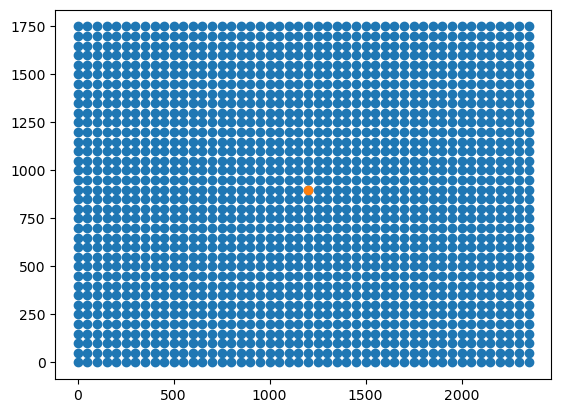

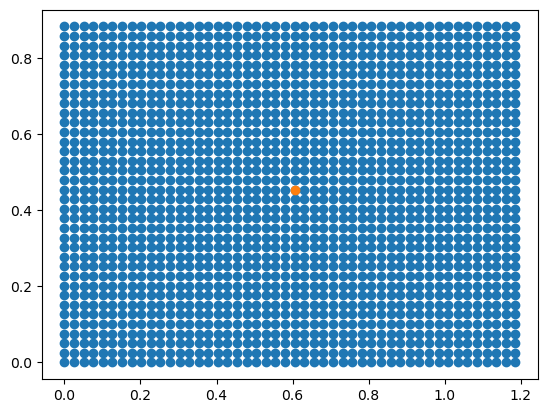

In [10]:
pos_pix = assemble_homog_pixel_vector(camera_1.width,camera_1.height,50)
plt.scatter(pos_pix[0],pos_pix[1])
plt.scatter(1200,896.5)
plt.show()

K1, R1, t1 = get_K_R_t(camera=camera_1, image=image_1, invert=True)
p_norm = K1.T @ np.array([1200,896.5,1]) # (x,y,1)


pos_norm = K1.T@pos_pix
pos_norm[2]=1
plt.scatter(pos_norm[0],pos_norm[1])
plt.scatter(p_norm[0],p_norm[1])
plt.show()

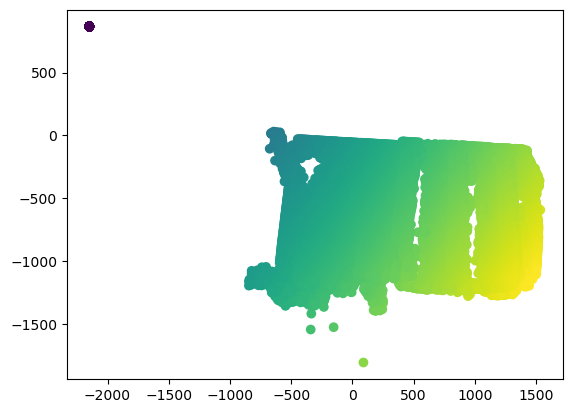

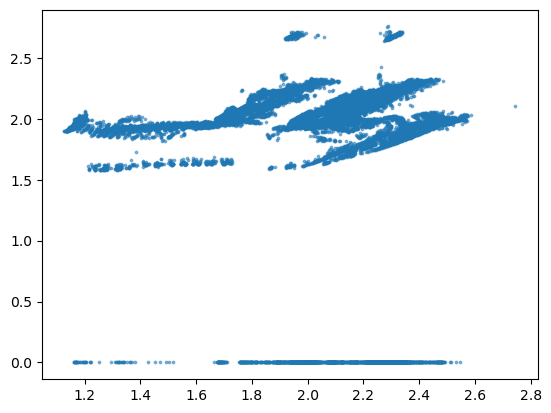

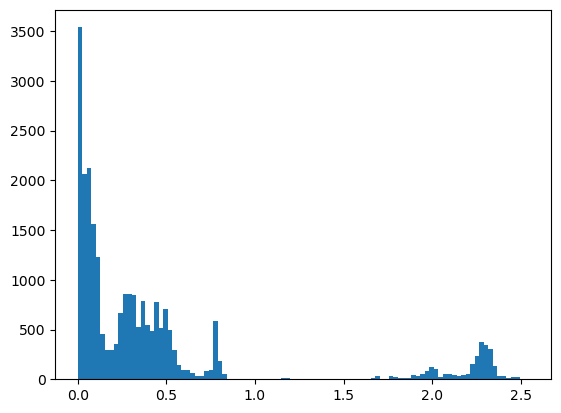

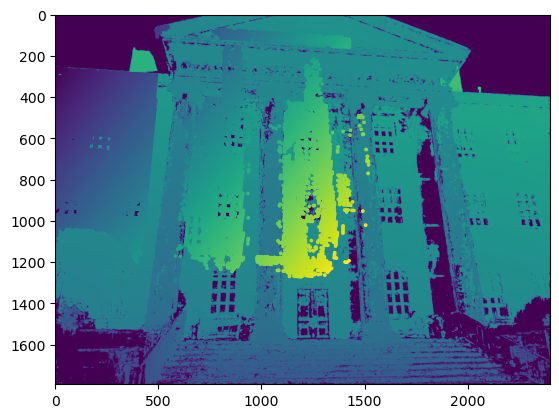

0.2543688417921547


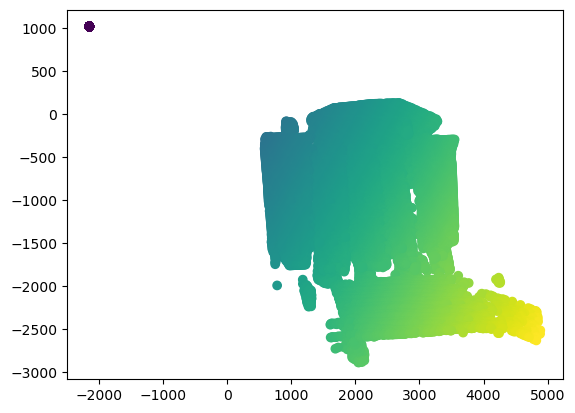

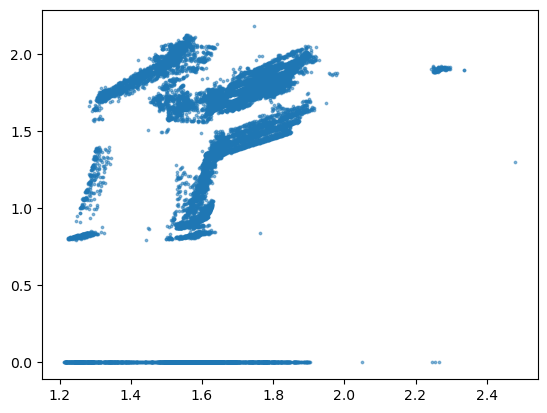

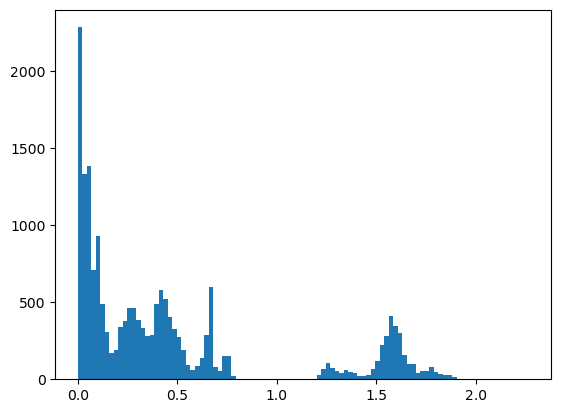

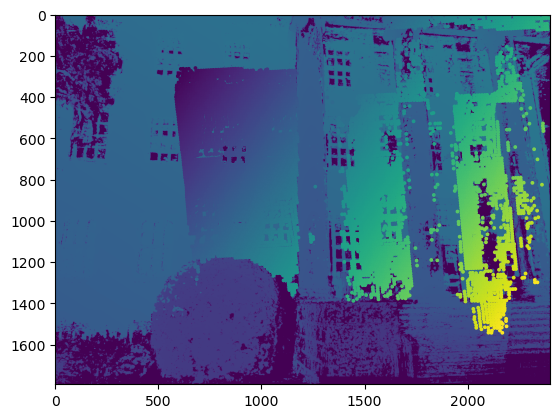

0.16861870236103363


In [11]:
def forwardproject(id_1,back2,down_sample=10):
    image_1 = image_dict[id_1]
    name_1 = image_dict[id_1].name
    camera_1 = camera_dict[image_1.camera_id]
    _, R1, t1 = get_K_R_t(camera=camera_1, image=image_1, invert=True)
    K1, _,_ = get_K_R_t(camera=camera_1, image=image_1, invert=False)
    
    homog_norm_vector = R1 @ back2 + t1.reshape(-1,1)
    # project
    z2 = homog_norm_vector[2]
    homog_norm_vector = homog_norm_vector/z2
    homog_pixel_vector = K1.T @ homog_norm_vector
    #plt.scatter(homog_norm_vector[0],homog_norm_vector[1],c=homog_norm_vector[2])
    #plt.show()
    plt.scatter(homog_pixel_vector[0],-homog_pixel_vector[1],c=homog_pixel_vector[2])
    plt.show()

    
    def filter_mask(data,w,h):
        # Get the x and y coordinates
        x = data[0]
        y = data[1]
        mask = (x >= 0) & (x <= w) & (y >= 0) & (y <= h)
        return mask
    
    mask = filter_mask(homog_pixel_vector,camera_1.width,camera_1.height)
    homog_pixel_vector = homog_pixel_vector[:, mask]
    
    depth_1 = read_array(os.path.join(dense_dir, "stereo", "depth_maps", f"{name_1}.geometric.bin"))

    x,y = homog_pixel_vector[:2].astype(int)
    gt_depth = depth_1[y,x]
    plt.scatter(z2[mask],gt_depth,s=3,alpha=0.5)
    plt.show()
    
    depth_error = np.abs(gt_depth-z2[mask])
    plt.hist(depth_error,bins=100)
    plt.show()
    
    inliner = depth_error<0.15
    plt.imshow(depth_1)
    plt.scatter(homog_pixel_vector[0,inliner],homog_pixel_vector[1,inliner],c=homog_pixel_vector[2,inliner],s=3)
    plt.show()
    
    score = np.count_nonzero(inliner)*down_sample*down_sample/camera_1.width/camera_1.height
    print(score)
    
back1 = backproject(id_1)
back2 = backproject(id_2)
forward1 = forwardproject(id_1,back2)
forward2 = forwardproject(id_2,back1)


In [ ]:
image_1 = image_dict[id_1]
image_2 = image_dict[id_2]

camera_1 = camera_dict[image_1.camera_id]
camera_2 = camera_dict[image_2.camera_id]

K1, R1, t1 = get_K_R_t(camera=camera_1, image=image_1, invert=True)
K2, R2, t2 = get_K_R_t(camera=camera_2, image=image_2, invert=False)

total_pixels = camera_1.height * camera_1.width
overlap_count = 0

for h in range(camera_1.height):
    for w in range(camera_1.width):
        if depth_1[h, w] == 0.0:
            continue
        
        # backproject
        p1 = np.array([h, w, 1]) # TODO: not sure yet if [w, h, 1] or [h, w, 1] is correct...
        P = R1 @ (K1 @ p1) + t1 
        
        # make sure that ||camera1 - P|| = depth_1[h, w]
        P = P / np.linalg.norm(image_1.tvec) * depth_1[h, w]

        # project it to the image space of camera 2
        p2 = K2 @ (R2 @ P + t2)

        # pixel coordinates of p2 in image 2
        # TODO: Check if p2 needs to be normalized first such that the 3rd component is 1
        x = int(p2[0]) # TODO: not sure yet about order of x and y...
        y = int(p2[1])

        if x < 0 or x >= camera_2.height or y < 0 or y >= camera_2.width:
            continue
        
        # check if distance approximately matches with actual depth value
        distance = np.linalg.norm(P - t2)
        if distance > 0.98 * depth_2[x, y] and distance < 1.02 * depth_2[x, y]:
            overlap_count += 1

overlap_score = overlap_count / total_pixels       
overlap_score